## Portfolio Exercise: Starbucks
<br>

<img src="https://opj.ca/wp-content/uploads/2018/02/New-Starbucks-Logo-1200x969.jpg" width="200" height="200">
<br>
<br>
 
#### Background Information

The dataset you will be provided in this portfolio exercise was originally used as a take-home assignment provided by Starbucks for their job candidates. The data for this exercise consists of about 120,000 data points split in a 2:1 ratio among training and test files. In the experiment simulated by the data, an advertising promotion was tested to see if it would bring more customers to purchase a specific product priced at $10. Since it costs the company 0.15 to send out each promotion, it would be best to limit that promotion only to those that are most receptive to the promotion. Each data point includes one column indicating whether or not an individual was sent a promotion for the product, and one column indicating whether or not that individual eventually purchased that product. Each individual also has seven additional features associated with them, which are provided abstractly as V1-V7.

#### Goal

The goal of this challenge is to use the training data to understand what patterns in V1-V7 to indicate that a promotion should be provided to a user. In essence, we want to come up with an robust optimization strategy to maximize the Incremental Response Rate (IRR) and the Net Incremental Revenue (NIR).

The leading research questions for this project are: 
1) Do promotion offers increase revenue increment (IRR) significantly?
2) How is it possible to maximize the Incremental Response Rate (IRR) and the Net Incremental Revenue (NIR)?

Hence, we want in the first place know if there's really a significant impact of promotions on the IRR and in a second step build a model which predicts if a customer purchases the product dependant on the features `v1 to v7`. We'll choose the model with the best score in terms of IRR & NIR which can be used by Starbucks to optimize their promotion sent outs.

#### How To Test Your Strategy?

When you feel like you have an optimization strategy, complete the `promotion_strategy` function to pass to the `test_results` function.  
From past data, we know there are four possible outomes:

Table of actual promotion vs. predicted promotion customers:  

<table>
<tr><th></th><th colspan = '2'>Actual</th></tr>
<tr><th>Predicted</th><th>Yes</th><th>No</th></tr>
<tr><th>Yes</th><td>I</td><td>II</td></tr>
<tr><th>No</th><td>III</td><td>IV</td></tr>
</table>

The metrics are only being compared for the individuals we predict should obtain the promotion – that is, quadrants I and II.  Since the first set of individuals that receive the promotion (in the training set) receive it randomly, we can expect that quadrants I and II will have approximately equivalent participants.  

Comparing quadrant I to II then gives an idea of how well your promotion strategy will work in the future. 

Get started by reading in the data below.  See how each variable or combination of variables along with a promotion influences the chance of purchasing.  When you feel like you have a strategy for who should receive a promotion, test your strategy against the test dataset used in the final `test_results` function.


Credits and inspiration: https://github.com/ZacksAmber/Starbucks/blob/main/notebooks/Starbucks.ipynb

<hr>

## Import libraries and load data

In [49]:
# load in packages
from itertools import combinations

from test_results import test_results, score
import numpy as np
import pandas as pd
import scipy as sp
import sklearn as sk
import scipy.stats as stats
from statsmodels.stats.proportion import proportions_ztest, proportion_effectsize
from statsmodels.stats.power import NormalIndPower

import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

# load in the data
test_data = pd.read_csv("../data/Test.csv")
train_data = pd.read_csv('../data/training.csv')
train_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,1,No,0,2,30.443518,-1.165083,1,1,3,2
1,3,No,0,3,32.159350,-0.645617,2,3,2,2
2,4,No,0,2,30.431659,0.133583,1,1,4,2
3,5,No,0,0,26.588914,-0.212728,2,1,4,2
4,8,Yes,0,3,28.044331,-0.385883,1,1,2,2


## First look into the data

### First Check

In [50]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84534 entries, 0 to 84533
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         84534 non-null  int64  
 1   Promotion  84534 non-null  object 
 2   purchase   84534 non-null  int64  
 3   V1         84534 non-null  int64  
 4   V2         84534 non-null  float64
 5   V3         84534 non-null  float64
 6   V4         84534 non-null  int64  
 7   V5         84534 non-null  int64  
 8   V6         84534 non-null  int64  
 9   V7         84534 non-null  int64  
dtypes: float64(2), int64(7), object(1)
memory usage: 6.4+ MB


In [51]:
train_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,1,No,0,2,30.443518,-1.165083,1,1,3,2
1,3,No,0,3,32.159350,-0.645617,2,3,2,2
2,4,No,0,2,30.431659,0.133583,1,1,4,2
3,5,No,0,0,26.588914,-0.212728,2,1,4,2
4,8,Yes,0,3,28.044331,-0.385883,1,1,2,2


In [52]:
train_data.describe()

,ID,purchase,V1,V2,V3,V4,V5,V6,V7
count,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000
mean,62970.972413,0.012303,1.500662,29.973600,0.000190,1.679608,2.327643,2.502898,1.701694
std,36418.440539,0.110234,0.868234,5.010626,1.000485,0.466630,0.841167,1.117349,0.457517
min,1.000000,0.000000,0.000000,7.104007,-1.684550,1.000000,1.000000,1.000000,1.000000
25%,31467.250000,0.000000,1.000000,26.591501,-0.905350,1.000000,2.000000,2.000000,1.000000
50%,62827.500000,0.000000,2.000000,29.979744,-0.039572,2.000000,2.000000,3.000000,2.000000
75%,94438.750000,0.000000,2.000000,33.344593,0.826206,2.000000,3.000000,4.000000,2.000000
max,126184.000000,1.000000,3.000000,50.375913,1.691984,2.000000,4.000000,4.000000,2.000000


In [53]:
for col in train_data.columns:
    print(f"{col}: {train_data[col].nunique()} unique values")

ID: 84534 unique values
Promotion: 2 unique values
purchase: 2 unique values
V1: 4 unique values
V2: 84518 unique values
V3: 40 unique values
V4: 2 unique values
V5: 4 unique values
V6: 4 unique values
V7: 2 unique values


Describing the variables, we can state the following assignments:

The Target variable: 
* `Purchase`: Nominal variable

Features:
* `V1`: Nominal or Categorical
* `V2`: Numerical scaled
* `V3`: Numerical scaled
* `V4`: Nominal or Categorical
* `V5`: Nominal or Categorical
* `V6`: Nominal or Categorical
* `V7`: Nominal or Categorical

### How many customers got a promotion and how many customers purchased the product?

In [54]:
train_data["Promotion"].value_counts()

Promotion
Yes    42364
No     42170
Name: count, dtype: int64

In [55]:
train_data["purchase"].value_counts()

purchase
0    83494
1     1040
Name: count, dtype: int64

The dataset is quite imbalanced concerning the feature "purchase"

### How many people purchased after a promotion?

In [56]:
train_data.groupby(["Promotion"])["purchase"].value_counts(normalize=False)

Promotion  purchase
No         0           41851
           1             319
Yes        0           41643
           1             721
Name: count, dtype: int64

In [57]:
train_data.groupby(["Promotion"])["purchase"].value_counts(normalize=True)

Promotion  purchase
No         0           0.992435
           1           0.007565
Yes        0           0.982981
           1           0.017019
Name: proportion, dtype: float64

### Is there a problem with missing values in the dataset?

In [58]:
train_data.isnull().sum()

ID           0
Promotion    0
purchase     0
V1           0
V2           0
V3           0
V4           0
V5           0
V6           0
V7           0
dtype: int64

### Is there a problem with class imbalance?

In [59]:
train_data.groupby(["Promotion"])["purchase"].value_counts(normalize=True)

Promotion  purchase
No         0           0.992435
           1           0.007565
Yes        0           0.982981
           1           0.017019
Name: proportion, dtype: float64

<hr>

## Key Metrics 

As mentioned before, we want to optimize the IRR and the NIR metric. To understand mathematically these key metrics in the following each of them are shortly ilustrated:

* **Incremental Response Rate (IRR)** 

IRR depicts how many more customers purchased the product with the promotion, as compared to if they didn't receive the promotion. Mathematically, it's the ratio of the number of purchasers in the promotion group to the total number of customers in the purchasers group (_treatment_) minus the ratio of the number of purchasers in the non-promotional group to the total number of customers in the non-promotional group (_control_).

$$ IRR = \frac{purch_{treat}}{cust_{treat}} - \frac{purch_{ctrl}}{cust_{ctrl}} $$


* **Net Incremental Revenue (NIR)**

NIR depicts how much is made (or lost) by sending out the promotion. Mathematically, this is 10 times the total number of purchasers that received the promotion minus 0.15 times the number of promotions sent out, minus 10 times the number of purchasers who were not given the promotion.

$$ NIR = (10\cdot purch_{treat} - 0.15 \cdot cust_{treat}) - 10 \cdot purch_{ctrl}$$


## Calculate the general baseline

Without any reference result, it is quite difficult to evaluate if a strategy steps in the correct direction. So, we calculate the baseline 
IRR / NIR of the train set:

In [60]:
train_data_prom = train_data[train_data["Promotion"]=="Yes"]
train_data_no_prom = train_data[train_data["Promotion"]=="No"]

n_1 = train_data_prom.shape[0]
n_2 = train_data_no_prom.shape[0]
n = n_1 + n_2 

purch_1 = train_data_prom[train_data_prom["purchase"] == 1].shape[0]
purch_2 = train_data_no_prom[train_data_no_prom["purchase"] == 1].shape[0]

Incremental Response Rate (IRR)

In [61]:
IRR = purch_1 / n_1 - purch_2 / n_2
IRR

0.009454547819772702

Net Incremental Revenue

In [62]:
NIR = (10 * purch_1 - 0.15 * n_1) - 10 * purch_2
NIR

-2334.5999999999995

If we want to maximize the: 
* IRR, we should maximize `purch_1 / n_1` and minimize `purch_2 / n_2`
* NIR, we should maximize `purch_1` and minimize `n_1` as well as `purch_2`

## Part I: A/B Testing of IRR

In this part, we'll investigate on the influence of promotions on the IRR. 
We will procede as follows:

* First of all, we'll calculate how many observations are necessary to insure a certain power for the hypothesis tests in the following steps
* Next we verify in a A/A Test if the group size of the two groups (with and without promotion) are equal in size to insure that the assertions deducted from the A/B Testing have a low chance to be random due to low sample size.
* Finally, we'll apply A/B Testing of the evaluation metric (IRR) 

## Calculate the necessary sample size to attain a certain Test Power

We state for our test setup an $\alpha$-error bareer of 5 % and a $\beta$-error of 20 % and therefore want to assume a Test-Power of 80 %. 
In this calculation we want to verify if our dataset already provides enough samples to lead to a Test-power of 80 %. 

In [63]:
#calculate and illustrate the purchase rate
p1 = purch_1 / n_1
p2 = purch_2 / n_2

print(f"""
    Purchase Rate of Control: {p2}
    Purchase Rate of Treatment: {p1}
    Purchase Rate Diff (p1-p2): {p1-p2}
    Purchase Rate Diff Ratio ((p1-p2) / p2): {(p1-p2)/p2}
    """)


    Purchase Rate of Control: 0.007564619397676073
    Purchase Rate of Treatment: 0.017019167217448776
    Purchase Rate Diff (p1-p2): 0.009454547819772702
    Purchase Rate Diff Ratio ((p1-p2) / p2): 1.2498378732282596
    


There is only a small absolute difference between the Treatment and the Control Group, but looking at the difference ratio, we can observe a quite high difference of 125 %.

In [64]:
alpha = 0.05
beta = 0.2 
power = 1 - beta

In [65]:
z_null = stats.norm.ppf(1 - alpha)
z_alt = stats.norm.ppf(beta)

sd_null = np.sqrt(p2 * (1-p2) + p2 * (1-p2))
sd_alt = np.sqrt(p2 * (1-p2) + p1 * (1-p1))

p_diff = p1 - p2
n_min = ((z_null*sd_null - z_alt * sd_alt) / p_diff) ** 2
np.ceil(n_min)

np.float64(1238.0)

In [66]:
power_analysis = NormalIndPower()
power_analysis.solve_power(
    effect_size=proportion_effectsize(p1, p2),
    alpha=alpha,
    power=power,
    alternative="larger",
)

1615.3610613913452

In the above calculations, we determined around 1238 to 1615 samples to attain a test power of 80 %. 
The treatment group size is $n_1 = 42364 > 1616$
And also the control group size is $n_2 = 42170 > 1616$
So we can be relatively sure that the sample size is sufficient for a statistical statement with a certain power.

## A/A Testing: Invariant Metric

A prerequisite for A/B testing is to insure that the groups included in the hypothesis test are in terms of numbers not significantly different from each other. 
If the groups differ significantly, we should not proceed to A/B Testing because the results could be biased. 

So we're applying A/A Testing under the following hypthesis:

$H_0: cust_{ctrl} = cust_{treat} $ <br>
$H_1: cust_{ctrl} \neq cust_{treat} $ <br>
$ p-val$ $assumption $: 0.5

In [67]:
p = 0.5
sd = np.sqrt(p * (1-p) * n)
z_score = ((n_2 + 0.5) - p * n) / sd
p_values = 2 * stats.norm.cdf(z_score)
p_values

np.float64(0.5068140685419046)

In [69]:
zstat, pval = proportions_ztest(
    count=n_2, nobs=n, value=0.5, alternative="two-sided", prop_var=False
)
zstat, pval

(np.float64(-0.6672478204244043), np.float64(0.5046138502146766))

In the test above we fail with a p-val of 0.504 to reject the $H_0$. This means that there is a very high probability that the number of customers in the treatment group is equally high as the number of customers in the control group. 

Hence, we can proceed to A/B Testing.

## A/B Testing: Evaluation Metric

As A/A Testing and the check of the experiment size passed, we can now test the evaluation metric.
It will be tested if the IRR of the treatment group is significantly higher than the IRR of the control group.
Mathematically spoken:

$H_0: \, IRR = 0$ <br>
$H_1: \, IRR > 0$

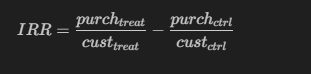

In [111]:
d0 = 0  # assume there is no difference between two groups
count = [purch_1, purch_2]
nobs = [n_1, n_2]

zstat, pval = proportions_ztest(
    count,
    nobs,
    value=d0,  # null hypothesis
    alternative="larger",
    prop_var=False,  # pooled
)
zstat, pval

(np.float64(12.468449461599388), np.float64(5.548209627035781e-36))

In [114]:
total_no_of_purchase = train_data[train_data["purchase"] == 1].shape[0]
prom_no_of_purchase = train_data[(train_data["Promotion"] == "Yes")&(train_data["purchase"] == 1)].shape[0]
no_prom_no_of_purchase = train_data[(train_data["Promotion"] == "No")&(train_data["purchase"] == 1)].shape[0]

total_purchase_rate = total_no_of_purchase / train_data.shape[0]
prom_purchase_rate = prom_no_of_purchase / train_data[train_data["Promotion"]=="Yes"].shape[0]
no_prom_purchase_rate = no_prom_no_of_purchase / train_data[train_data["Promotion"]=="No"].shape[0]

In [115]:
print(f"""
    Total no of purchase: {total_no_of_purchase}
    No of purchases linked to promotion: {prom_no_of_purchase}
    No of purchases not linked to promotion: {no_prom_no_of_purchase}
      """)


    Total no of purchase: 1040
    No of purchases linked to promotion: 721
    No of purchases not linked to promotion: 319
      


In [118]:
se_p = np.sqrt(total_purchase_rate * (1-total_purchase_rate) * (1 / n_2 + 1 / n_1))

z_score = (prom_purchase_rate - no_prom_purchase_rate) / se_p

In [119]:
print(f"Standard Error: {se_p}")
print(f"Z-Score: {z_score}")
print('p value: ', 1 - stats.norm.cdf(z_score))

Standard Error: 0.00075827775128664
Z-Score: 12.468449461599388
p value:  0.0


**Conclusion**
 


From the test results we can deduct that the $H_0$ Hypothesis can be rejected even on a $\alpha$ = 1% level. We can though be confident that there is a statistically significant difference between the groups (99% sure) concerning the purchase_rate.
We can infer that the promotions provided successfully increase the purchase rate.<br>
Concerning practical significance for this project no definition was given and therefore we can assume that the statistical borders are binding.
So our model in the following has to be better than an increase of 125 % of purchase increase.

# Part II: Create a Model to determine the promotion-relevant customer

In [ ]:
def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    
    
    
    
    return promotion

In [ ]:
# This will test your results, and provide you back some information 
# on how well your promotion_strategy will work in practice

test_results(promotion_strategy)